In [1]:
import lal
import torch
import numpy as np
import jax.numpy as jnp
import lalsimulation as lalsim
import matplotlib.pyplot as plt
from torch import Tensor
from phenom_p import IMRPhenomPv2
from IMRPhenomPv2 import gen_IMRPhenomPv2_hphc, gen_IMRPhenomPv2

params = {
    "text.usetex": True,
    "font.family": "serif",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.top": True,
    "ytick.left": True,
    "ytick.right": True,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.minor.size": 2.5,
    "xtick.major.size": 5,
    "ytick.minor.size": 2.5,
    "ytick.major.size": 5,
    "axes.axisbelow": True,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.labelsize": 18,
    "legend.fontsize": 14,
    "legend.title_fontsize": 16,
    "figure.titlesize": 22,
    "axes.labelpad": 10.0,
}
plt.rcParams.update(params)

/tmp/ipykernel_12650/1783826325.py:1: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
def ms_to_Mc_eta(m):
    r"""
    Converts binary component masses to chirp mass and symmetric mass ratio.

    Args:
        m: the binary component masses ``(m1, m2)``

    Returns:
        :math:`(\mathcal{M}, \eta)`, with the chirp mass in the same units as
        the component masses
    """
    m1, m2 = m
    return (m1 * m2) ** (3 / 5) / (m1 + m2) ** (1 / 5), m1 * m2 / (m1 + m2) ** 2

In [3]:
# Frequency grid
T = 128
f_l = 20.0
f_sampling = 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

In [19]:
m1_msun = Tensor([40])
m2_msun = Tensor([25])
chirp_mass = Tensor([(m1_msun * m2_msun) ** (3 / 5) / (m1_msun + m2_msun) ** (1 / 5)])
mass_ratio = Tensor([m1_msun / m2_msun])
m1_kg = Tensor([m1_msun * lal.MSUN_SI])
m2_kg = Tensor([m2_msun * lal.MSUN_SI])
chi1z = Tensor([0.1])
chi2z = Tensor([-0.1])
chi1x = Tensor([-0.2])
chi2x = Tensor([0.2])
chi1y = Tensor([0.9])
chi2y = Tensor([-0.4])
dist_mpc = Tensor([100])
distance = Tensor([dist_mpc * 1e6 * lal.PC_SI])
tc = Tensor([0])
phic = Tensor([torch.pi])
inclination = Tensor([0])
Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun.item(), m2_msun.item()]))
theta_ripple = jnp.array(
    [
        m1_msun.item(),
        m2_msun.item(),
        chi1x.item(),
        chi1y.item(),
        chi1z.item(),
        chi2x.item(),
        chi2y.item(),
        chi2z.item(),
        dist_mpc.item(),
        tc.item(),
        phic.item(),
        inclination.item(),
    ]
)
fs_ripple = jnp.arange(f_l, f_u, df)[1:]
fs_torch = Tensor(np.arange(f_l, f_u, df)[1:])

laldict = None
IMRphenom = "IMRPhenomPv2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

In [20]:
hp, hc = lalsim.SimInspiralChooseFDWaveform(
    m1_kg.item(),
    m2_kg.item(),
    chi1x.item(),  # this is chi1x
    chi1y.item(),  # this is chi1y
    chi1z.item(),  # this is chi1z
    chi2x.item(),  # this is chi2x
    chi2y.item(),  # this is chi2y
    chi2z.item(),  # this is chi2z
    distance.item(),
    inclination.item(),
    phic.item(),
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df
mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]
hc_lalsuite = hc.data.data[mask_lal]

f = freqs_lal[mask_lal]

hp_ripple, hc_ripple = gen_IMRPhenomPv2(fs_ripple, theta_ripple, f_ref)
hc_torch, hp_torch = IMRPhenomPv2().forward(
    fs_torch,
    chirp_mass,
    mass_ratio,
    chi1x,
    chi1y,
    chi1z,
    chi2x,
    chi2y,
    chi2z,
    dist_mpc,
    phic,
    inclination,
    f_ref,
    tc,
)
hp_torch, hc_torch = hp_torch[0].numpy(), hc_torch[0].numpy()

In [6]:
diff_lal_ripple = np.maximum(
    np.abs(hp_lalsuite - hp_ripple), np.abs(hc_lalsuite - hc_ripple)
)
diff_lal_torch = np.maximum(
    np.abs(hp_lalsuite - hp_torch), np.abs(hc_lalsuite - hc_torch)
)
diff_ripple_torch = np.maximum(
    np.abs(hp_ripple - hp_torch), np.abs(hc_ripple - hc_torch)
)

# **Jax vs LAL**

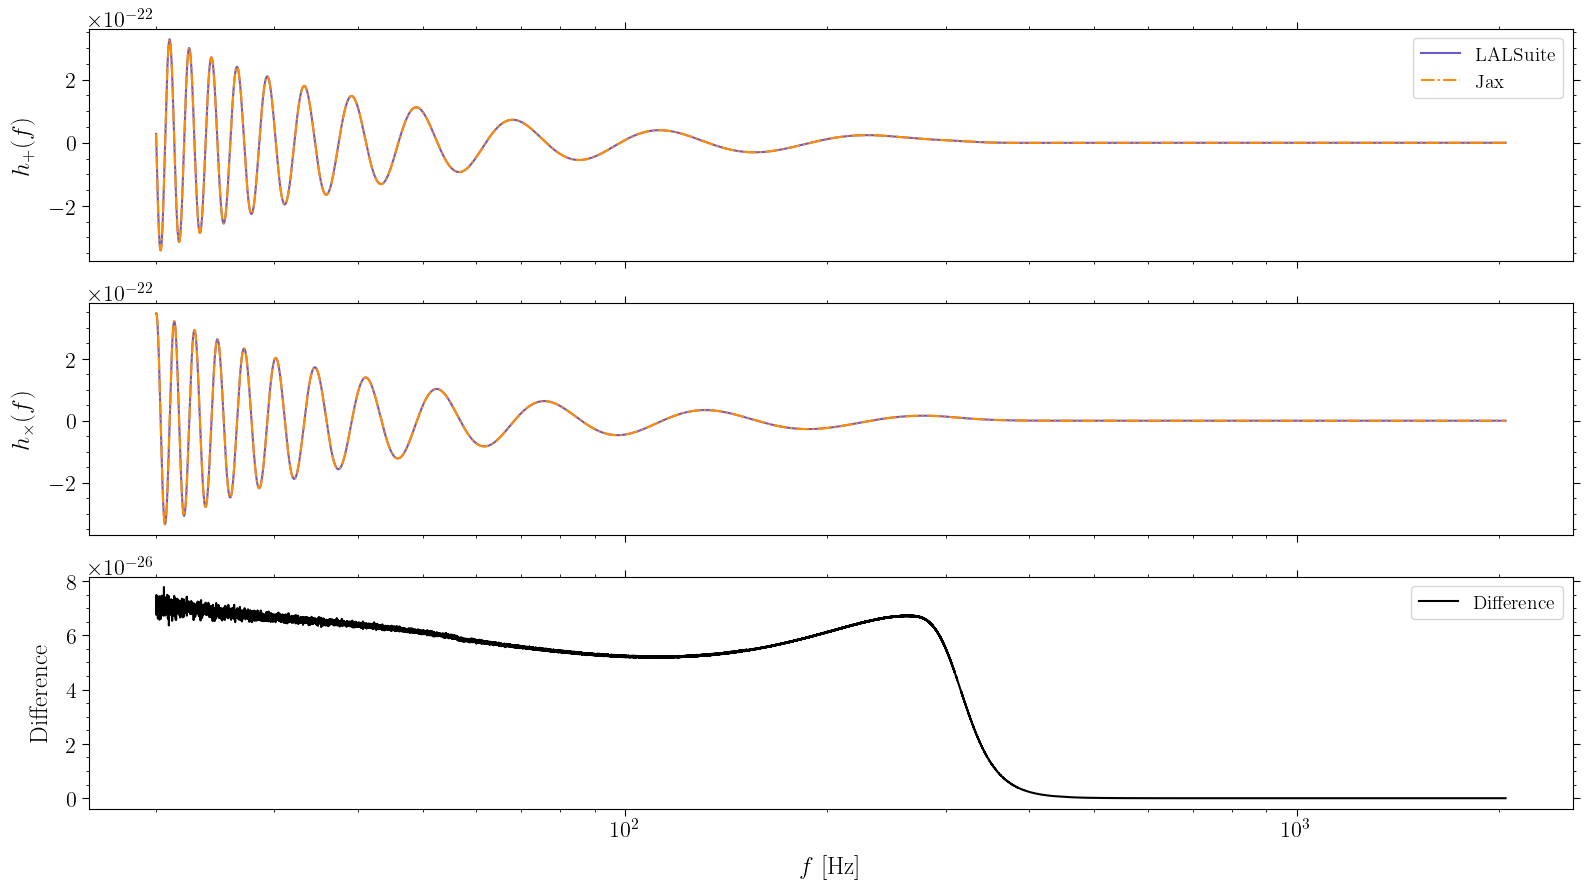

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

ax[0].plot(f, hp_lalsuite.real, label="LALSuite", color="slateblue")
ax[0].plot(f, hp_ripple.real, label="Jax", color="darkorange", linestyle="-.")
ax[0].set_ylabel(r"$h_+ (f)$")
ax[0].set_xscale("log")
ax[0].legend()

ax[1].plot(f, hc_lalsuite.real, label="LALSuite", color="slateblue")
ax[1].plot(f, hc_ripple.real, label="Jax", color="darkorange", linestyle="-.")
ax[1].set_ylabel(r"$h_\times (f)$")

ax[2].plot(f, diff_lal_ripple, label="Difference", color="black")
ax[2].set_ylabel(r"Difference")
ax[2].set_xlabel(r"$f$ [Hz]")
ax[2].legend()

fig.tight_layout()
plt.show()

# **Torch vs LAL**

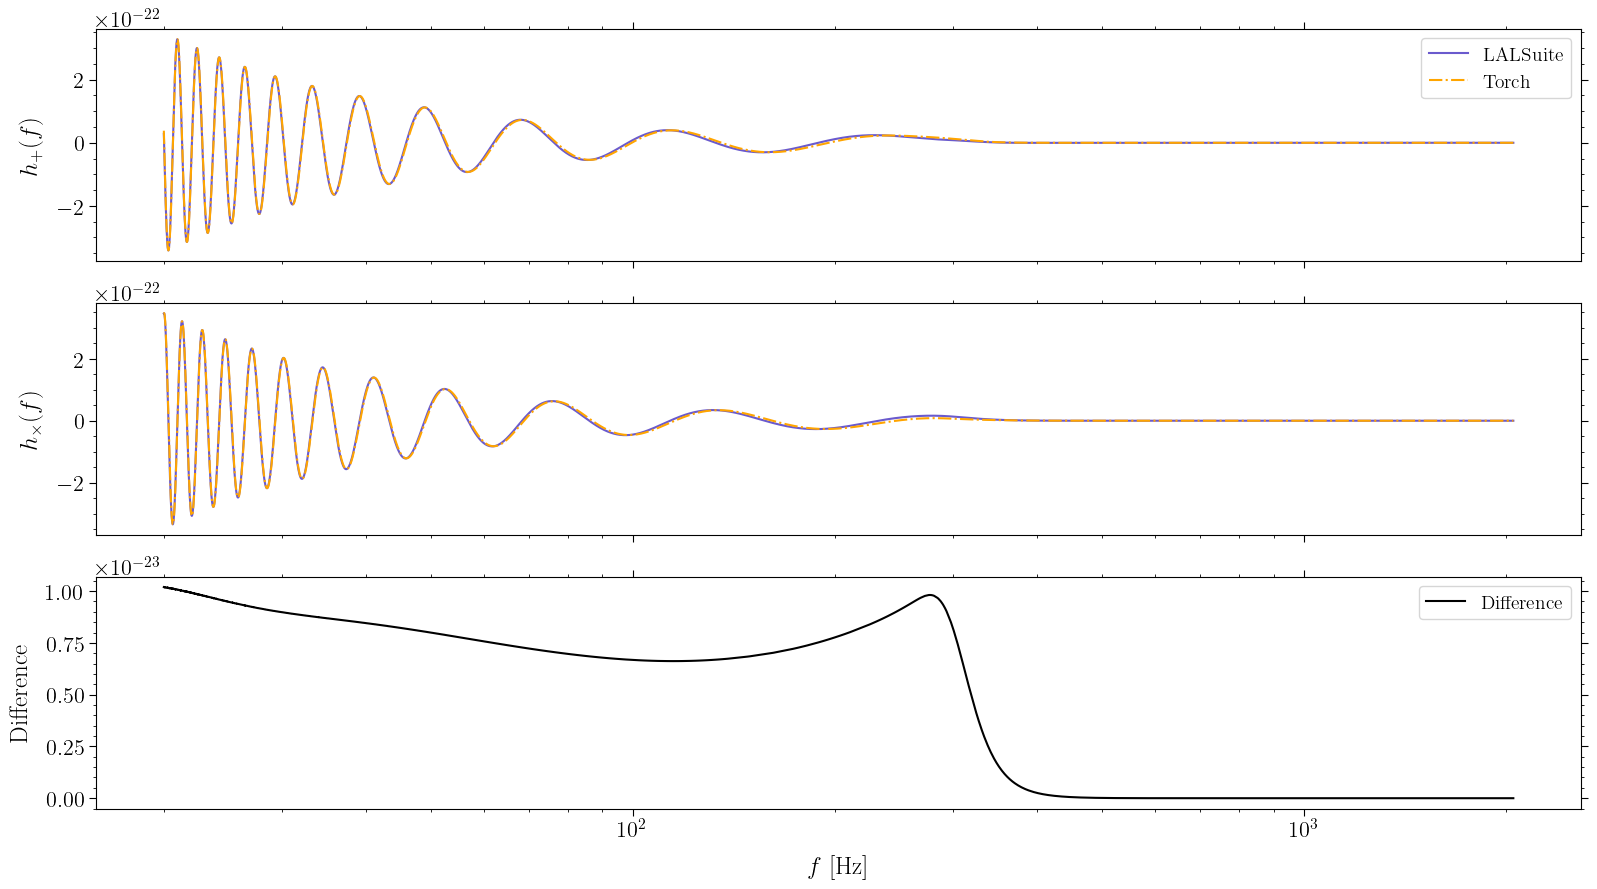

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

ax[0].plot(f, hp_lalsuite.real, label="LALSuite", color="slateblue")
ax[0].plot(f, hp_torch.real, label="Torch", color="orange", linestyle="-.")
ax[0].set_ylabel(r"$h_+ (f)$")
ax[0].set_xscale("log")
ax[0].legend()

ax[1].plot(f, hc_lalsuite.real, label="LALSuite", color="slateblue")
ax[1].plot(f, hc_torch.real, label="Torch", color="orange", linestyle="-.")
ax[1].set_ylabel(r"$h_\times (f)$")

ax[2].plot(f, diff_lal_torch, label="Difference", color="black")
ax[2].set_ylabel(r"Difference")
ax[2].set_xlabel(r"$f$ [Hz]")
ax[2].legend()

fig.tight_layout()
plt.show()

# **Torch vs Jax**

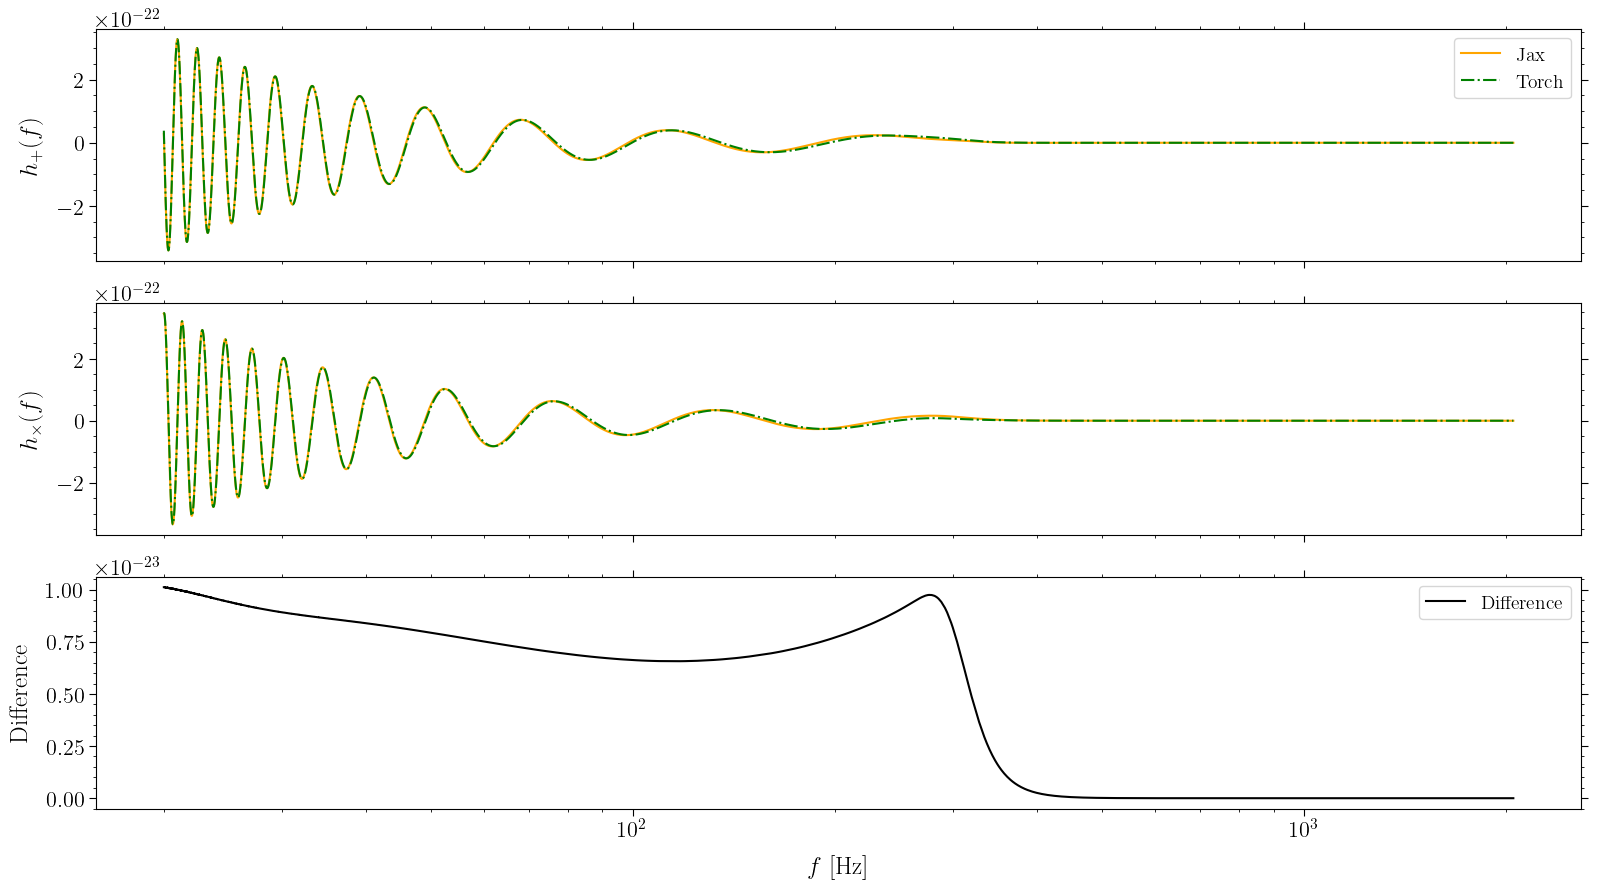

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

ax[0].plot(f, hp_ripple.real, label="Jax", color="orange")
ax[0].plot(f, hp_torch.real, label="Torch", color="green", linestyle="-.")
ax[0].set_ylabel(r"$h_+ (f)$")
ax[0].set_xscale("log")
ax[0].legend()

ax[1].plot(f, hc_ripple.real, label="Jax", color="orange")
ax[1].plot(f, hc_torch.real, label="Torch", color="green", linestyle="-.")
ax[1].set_ylabel(r"$h_\times (f)$")

ax[2].plot(f, diff_ripple_torch, label="Difference", color="black")
ax[2].set_ylabel(r"Difference")
ax[2].set_xlabel(r"$f$ [Hz]")
ax[2].legend()

fig.tight_layout()
plt.show()

In [10]:
np.max(1e21 * np.abs(hp_torch.real - hp_lalsuite.real)), np.max(
    1e21 * np.abs(hc_torch.real - hc_lalsuite.real)
), np.max(1e21 * np.abs(hp_lalsuite.imag - hp_torch.imag)), np.max(
    1e21 * np.abs(hc_lalsuite.imag - hc_torch.imag)
)

(0.40377388085810606,
 0.40408397620448694,
 0.4040839635827125,
 0.40377388085810606)

In [11]:
from pycbc.conversions import (
    mchirp_from_mass1_mass2,
    q_from_mass1_mass2,
    mass1_from_mchirp_q,
    mass2_from_mchirp_q,
)

print(q_from_mass1_mass2(20, 25))
print(mchirp_from_mass1_mass2(20, 25))
print(mass1_from_mchirp_q(30, 0.5))
print(mass2_from_mchirp_q(30, 0.5))

1.25
19.441935582935386
24.656277442758384
49.31255488551677


In [12]:
mass1 = 19.441935582935386 * (1 + 1.25) ** 0.2 / 1.25**0.6
mass2 = mass1 * 1.25
print(mass1, mass2)

20.0 25.0
